# MNIST TUTORIAL

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()

Note: you may need to restart the kernel to use updated packages.


### Download the video and load it into EvaDB

In [2]:
# Getting MNIST as a video
!wget -nc https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4

# Load the video into EvaDB
cursor.query("DROP TABLE IF EXISTS MNISTVid").df()
cursor.load("mnist.mp4", "MNISTVid", format="video").df()

File ‘mnist.mp4’ already there; not retrieving.



,0
0,Number of loaded VIDEO: 1


### Run the Image Classification Function over the video

In [3]:
# Connecting to the table with the loaded video
query = cursor.table("MNISTVid")

# Here, id refers to the frame id
# Each frame in the loaded MNIST video contains a digit
query = query.filter("id = 30 OR id = 50 OR id = 70 OR id = 0 OR id = 140")

# We are retrieving the frame "data" and 
# the output of the Image Classification function on the data 
# ("MnistImageClassifier(data).label")
query = query.select("data, MnistImageClassifier(data).label")

response = query.df()

### Visualize output of query on the video

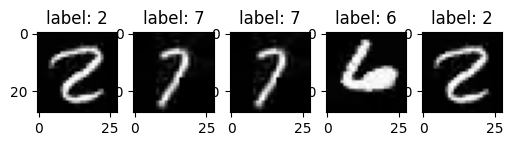

In [4]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[6,8])

for axi in ax.flat:
    idx = np.random.randint(len(response))
    img = response['mnistvid.data'].iloc[idx]
    label = response['mnistimageclassifier.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()

### Drop the function if needed

In [5]:
cursor.drop_udf("MnistImageClassifier").df()

,0
0,UDF MnistImageClassifier successfully dropped
